## Variational Autoencoder Big

In [1]:
from keras.utils.vis_utils import plot_model
from keras_visualizer import visualizer
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from autoencoders.VAE import VAE as VAE

DATASET_SIZE = 25084
INPUT_SHAPE = (40, 30, 1)

In [2]:
import tensorflow as tf

devices = tf.config.list_physical_devices('GPU')

if len(devices) < 1:
    raise Exception("Cannot initialize GPU")

print("GPU configured correctly")

GPU configured correctly


In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    horizontal_flip=True,
    vertical_flip=True
)
# Allow horizontal flip and vertical flip as a mirror image in both axes of a game is a valid game state

train_datagen = datagen.flow_from_directory(
    'images_paddleless_big/',
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    color_mode='grayscale',
    class_mode='input',
    shuffle=True,
    subset='training'
)

val_datagen = datagen.flow_from_directory(
    'images_paddleless_big/',
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    color_mode='grayscale',
    class_mode='input',
    shuffle=True,
    subset='validation'
)

Found 9706 images belonging to 1 classes.
Found 4159 images belonging to 1 classes.


In [4]:
vae = VAE(
    layers=5,
    latent_size=12,
    kernel_size=3,
    filters=8,
    beta=1,
    input_shape=INPUT_SHAPE,
    name="VAE"
)
vae.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_encoder (InputLayer)      [(None, 40, 30, 1)]  0                                            
__________________________________________________________________________________________________
conv1_enc (Conv2D)              (None, 40, 30, 8)    80          input_encoder[0][0]              
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 20, 15, 8)    0           conv1_enc[0][0]                  
__________________________________________________________________________________________________
conv2_enc (Conv2D)              (None, 20, 15, 16)   1168        maxpool1[0][0]                   
____________________________________________________________________________________________

In [5]:
callbacks = [
    #EarlyStopping(monitor='val_loss', patience=15),
    #TensorBoard(
    #    log_dir='./logs',
    #    histogram_freq=1
    #)
]

history = vae.train(
    train_datagen, 
    val_datagen, 
    epochs=100, 
    callbacks=callbacks
)


304/304 [==============================] - 3s 10ms/step - loss: 27.0230 - reconstruction_loss: 14.7217 - kl_loss: 11.8968 - val_loss: 26.0460 - val_reconstruction_loss: 14.3695 - val_kl_loss: 11.6765
Epoch 7/100
304/304 [==============================] - 3s 10ms/step - loss: 25.2656 - reconstruction_loss: 13.6588 - kl_loss: 11.3310 - val_loss: 23.4068 - val_reconstruction_loss: 12.7528 - val_kl_loss: 10.6540
Epoch 8/100
304/304 [==============================] - 3s 10ms/step - loss: 23.4311 - reconstruction_loss: 12.2497 - kl_loss: 10.5508 - val_loss: 21.4964 - val_reconstruction_loss: 11.3001 - val_kl_loss: 10.1963
Epoch 9/100
304/304 [==============================] - 3s 10ms/step - loss: 21.0252 - reconstruction_loss: 10.7264 - kl_loss: 9.9643 - val_loss: 23.8840 - val_reconstruction_loss: 14.3911 - val_kl_loss: 9.4930
Epoch 10/100
304/304 [==============================] - 3s 10ms/step - loss: 20.6651 - reconstruction_loss: 10.6256 - kl_loss: 9.8521 - val_loss: 17.3971 - val_recon

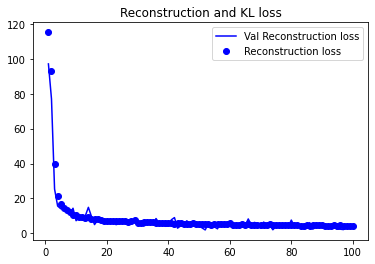

In [6]:
val_rec_loss = history.history['val_reconstruction_loss']
rec_loss = history.history['reconstruction_loss']

epochs = range(1, len(val_rec_loss) + 1)    

plt.plot(epochs, val_rec_loss, 'b', label='Val Reconstruction loss')
plt.plot(epochs, rec_loss, 'bo', label='Reconstruction loss')
plt.title('Reconstruction and KL loss')
#plt.gca().set_ylim([0, 20])
plt.legend()

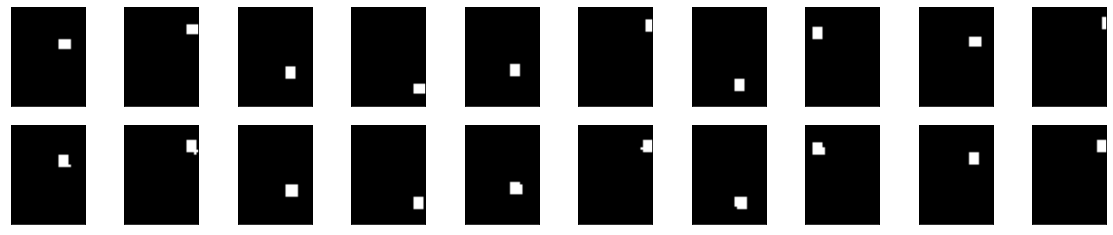

In [7]:
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import random

n = 10
images = np.empty((n, *INPUT_SHAPE))

files = os.listdir("./images_paddleless_big/")
rand_img = random.randint(0, len(files) -10)

for i in range(n):
    #print(files[rand_img+i])
    img = img_to_array(load_img(f"images_paddleless_big/{files[rand_img+i]}", color_mode='grayscale'))
    images[i] = img

decoded_imgs = vae.predict(images)
latent = vae.encoder.predict(images)

#print(latent[:][2])

decoded_imgs = vae.decoder.predict(latent[:][2])

plt.figure(figsize=(20, 4))

for i in range(1, n+1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(images[i-1].reshape(INPUT_SHAPE[0], INPUT_SHAPE[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i-1].reshape(INPUT_SHAPE[0], INPUT_SHAPE[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

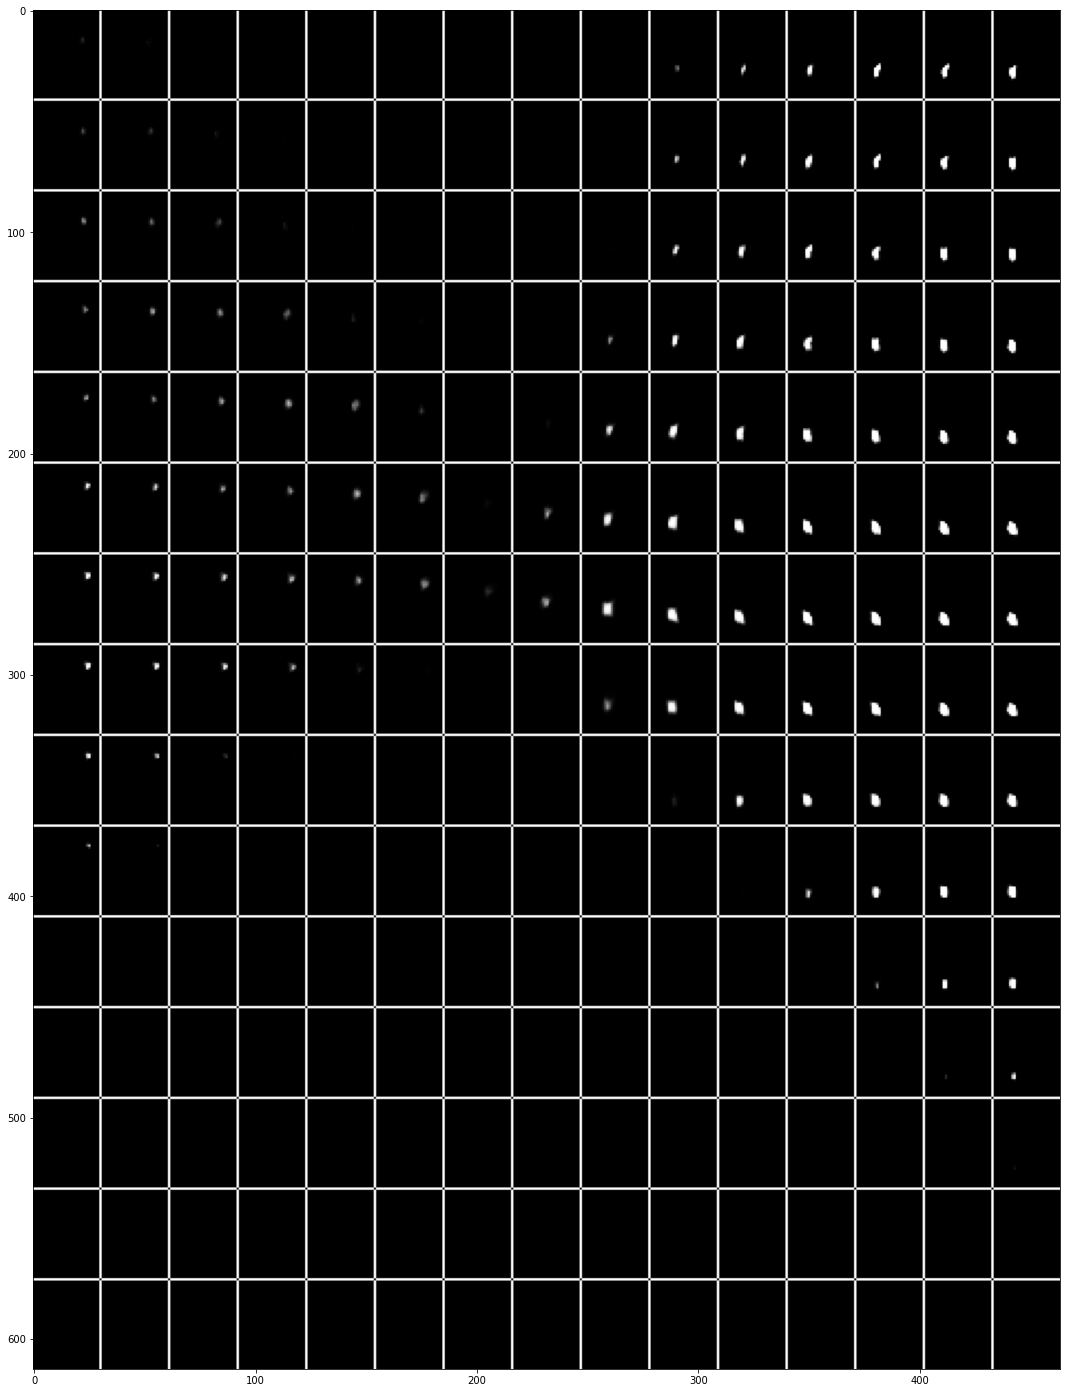

In [8]:
import random

def plot_latent_space(vae, n=15, figsize=25):
    # display a n*n 2D manifold of digits
    x_input_size = INPUT_SHAPE[0]
    y_input_size = INPUT_SHAPE[1]
    scale = 300.0
    figure = np.zeros((x_input_size * n + n - 1, y_input_size * n + n - 1))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            
            rest = [0] * 10
            # missing =  4.5645156e+00,  1.5707643e+01,    
            z_sample = np.array([[xi, yi] + rest])
            #z_sample = np.array([[random.randint(-scale, scale) for i in range(16)]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(x_input_size, y_input_size)
            figure[
                i * x_input_size + i: (i + 1) * x_input_size + i,
                j * y_input_size + j: (j + 1) * y_input_size + j,
            ] = digit

            if i != len(grid_x) - 1:
                figure[
                    (i + 1) * x_input_size + i,
                    j * y_input_size + j: (j + 1) * y_input_size + j,
                ] = np.array([1] * y_input_size)
            if j != len(grid_y) - 1:
                figure[
                    i * x_input_size + i: (i + 1) * x_input_size + i,
                    (j + 1) * y_input_size + j,
                ] = np.array([1] * x_input_size)

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

In [10]:
vae.model.save("models/vae_big_paddleless")

INFO:tensorflow:Assets written to: models/vae_big_paddleless/assets
